[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_isbla46khJwEm3khLQshMVTWJoPJr7w?usp=sharing)

# setup

In [20]:
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import joblib

In [21]:
# Download dataset
file_id = '1HIJVXKQwABrxDVoKj3eMTCmQ7T8LinF8'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
gdown.download(url, 'dataset.csv', quiet=False)

# Load data with error handling
try:
    df = pd.read_csv('dataset.csv', encoding='latin1')
except Exception as e:
    print(f"Error loading file: {e}")
    # Try alternative encodings if needed
    try:
        df = pd.read_csv('dataset.csv', encoding='ISO-8859-1')
    except:
        df = pd.read_csv('dataset.csv', encoding='utf-8', errors='ignore')

# Enhanced data inspection
def inspect_data(df):
    print("=== DATA INSPECTION ===")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes.value_counts())

    print("\nMissing Values Summary:")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    print("\nDuplicate Rows:", df.duplicated().sum())

    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        print("\nNumeric Columns Statistics:")
        print(df[numeric_cols].describe().T)

    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\nCategorical Columns Summary:")
        for col in cat_cols:
            print(f"\n{col}:")
            print(df[col].value_counts(dropna=False).head())

inspect_data(df)

# Advanced cleaning function
def clean_data(df, outlier_threshold=1.5):
    # Make a copy
    clean_df = df.copy()

    # Handle missing values
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    numeric_cols = clean_df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        clean_df[numeric_cols] = num_imputer.fit_transform(clean_df[numeric_cols])

    cat_cols = clean_df.select_dtypes(include=['object']).columns
    if len(cat_cols) > 0:
        clean_df[cat_cols] = cat_imputer.fit_transform(clean_df[cat_cols])

    # Handle outliers using IQR method
    for col in numeric_cols:
        q1 = clean_df[col].quantile(0.25)
        q3 = clean_df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - outlier_threshold * iqr
        upper = q3 + outlier_threshold * iqr
        clean_df[col] = np.where(clean_df[col] < lower, lower,
                                np.where(clean_df[col] > upper, upper, clean_df[col]))

    # Remove duplicates
    clean_df = clean_df.drop_duplicates()

    # Convert object types to category for memory efficiency
    for col in cat_cols:
        clean_df[col] = clean_df[col].astype('category')

    return clean_df

cleaned_df = clean_data(df)
print("\nData cleaning completed. New shape:", cleaned_df.shape)


Downloading...
From: https://drive.google.com/uc?export=download&id=1HIJVXKQwABrxDVoKj3eMTCmQ7T8LinF8
To: /content/dataset.csv
100%|██████████| 45.6M/45.6M [00:00<00:00, 79.7MB/s]


=== DATA INSPECTION ===
Shape: (541909, 8)

Data Types:
object     5
float64    2
int64      1
Name: count, dtype: int64

Missing Values Summary:
Description      1454
CustomerID     135080
dtype: int64

Duplicate Rows: 5268

Numeric Columns Statistics:
               count          mean          std       min       25%       50%  \
Quantity    541909.0      9.552250   218.081158 -80995.00      1.00      3.00   
UnitPrice   541909.0      4.611114    96.759853 -11062.06      1.25      2.08   
CustomerID  406829.0  15287.690570  1713.600303  12346.00  13953.00  15152.00   

                 75%      max  
Quantity       10.00  80995.0  
UnitPrice       4.13  38970.0  
CustomerID  16791.00  18287.0  

Categorical Columns Summary:

InvoiceNo:
InvoiceNo
573585    1114
581219     749
581492     731
580729     721
558475     705
Name: count, dtype: int64

StockCode:
StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: count, dtype: int64

Description:
Des

# Feature Selection

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, chi2, f_classif, f_regression,
    mutual_info_classif, mutual_info_regression
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.multiclass import type_of_target

def feature_selection(df, target_col, corr_thresh=0.9, mi_top_k=10, chi2_top_k=10, anova_top_k=10, visualize=True):
    df_fs = df.copy()

    # Pisahkan target
    y = df_fs[target_col]
    X = df_fs.drop(columns=[target_col])

    # Encode target jika kategorikal
    if y.dtype.name == 'category' or y.dtype == object:
        y = LabelEncoder().fit_transform(y)

    # Deteksi tipe target
    target_type = type_of_target(y)
    is_classification = target_type in ['binary', 'multiclass']
    print(f"\n🔍 Target type detected: {target_type} → {'Classification' if is_classification else 'Regression'}")

    # Ambil hanya fitur numerik
    X = X.select_dtypes(include=[np.number])

    print("\n=== 1. Constant and Quasi-Constant Features ===")
    selector = VarianceThreshold(threshold=0.01)
    selector.fit(X)
    constant_features = X.columns[~selector.get_support()]
    print("Removed:", list(constant_features))
    X = X.loc[:, selector.get_support()]

    print("\n=== 2. Duplicate Features ===")
    duplicates = []
    cols = X.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if X[cols[i]].equals(X[cols[j]]):
                duplicates.append(cols[j])
    print("Removed:", list(set(duplicates)))
    X = X.drop(columns=list(set(duplicates)))

    print("\n=== 3. Correlation Filter ===")
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_thresh)]
    print("Removed:", to_drop)
    X = X.drop(columns=to_drop)

    if visualize and not corr_matrix.empty:
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()

    print("\n=== 4. Mutual Information ===")
    if is_classification:
        mi_scores = mutual_info_classif(X, y, discrete_features='auto')
    else:
        mi_scores = mutual_info_regression(X, y)
    mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    print(mi_series.head(mi_top_k))

    if visualize:
        mi_series.sort_values().plot(kind='barh', title='Mutual Information Scores', figsize=(8, 6))
        plt.xlabel('Score')
        plt.tight_layout()
        plt.show()

    print("\n=== 5. Chi-Square Test ===")
    if is_classification:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        chi2_selector = SelectKBest(score_func=chi2, k='all')
        chi2_selector.fit(X_scaled, y)
        chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns).sort_values(ascending=False)
        print(chi2_scores.head(chi2_top_k))

        if visualize:
            chi2_scores.sort_values().plot(kind='barh', title='Chi-Square Scores', figsize=(8, 6), color='green')
            plt.xlabel('Score')
            plt.tight_layout()
            plt.show()
    else:
        print("Chi-Square skipped (only for classification targets).")

    print("\n=== 6. ANOVA / F-Regression ===")
    if is_classification:
        anova_selector = SelectKBest(score_func=f_classif, k='all')
    else:
        anova_selector = SelectKBest(score_func=f_regression, k='all')
    anova_selector.fit(X, y)
    anova_scores = pd.Series(anova_selector.scores_, index=X.columns).sort_values(ascending=False)
    print(anova_scores.head(anova_top_k))

    if visualize:
        anova_scores.sort_values().plot(kind='barh', title='ANOVA / F-Regression Scores', figsize=(8, 6), color='orange')
        plt.xlabel('F-Score')
        plt.tight_layout()
        plt.show()

    print("\n✅ Feature selection completed.")
    return X



🔍 Target type detected: continuous → Regression

=== 1. Constant and Quasi-Constant Features ===
Removed: []

=== 2. Duplicate Features ===
Removed: []

=== 3. Correlation Filter ===
Removed: []


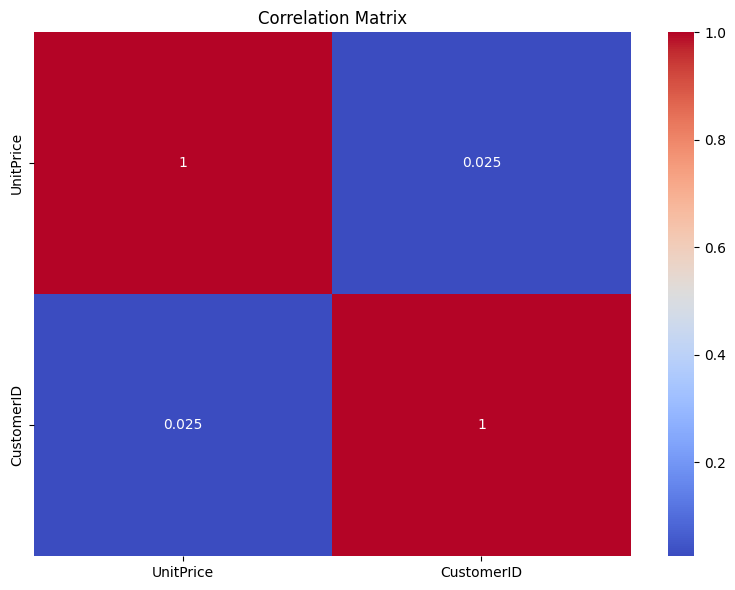


=== 4. Mutual Information ===
CustomerID    0.455287
UnitPrice     0.356636
dtype: float64


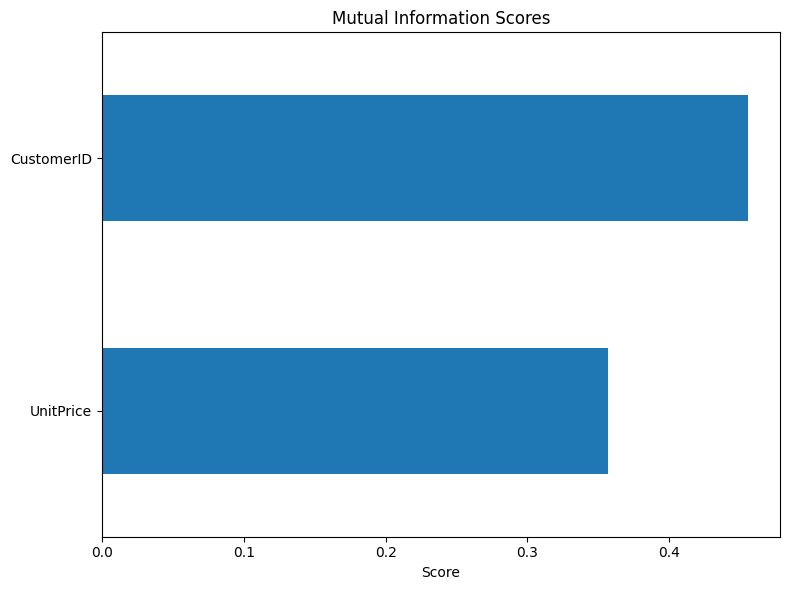


=== 5. Chi-Square Test ===
Chi-Square skipped (only for classification targets).

=== 6. ANOVA / F-Regression ===
UnitPrice     80643.463838
CustomerID     4578.626963
dtype: float64


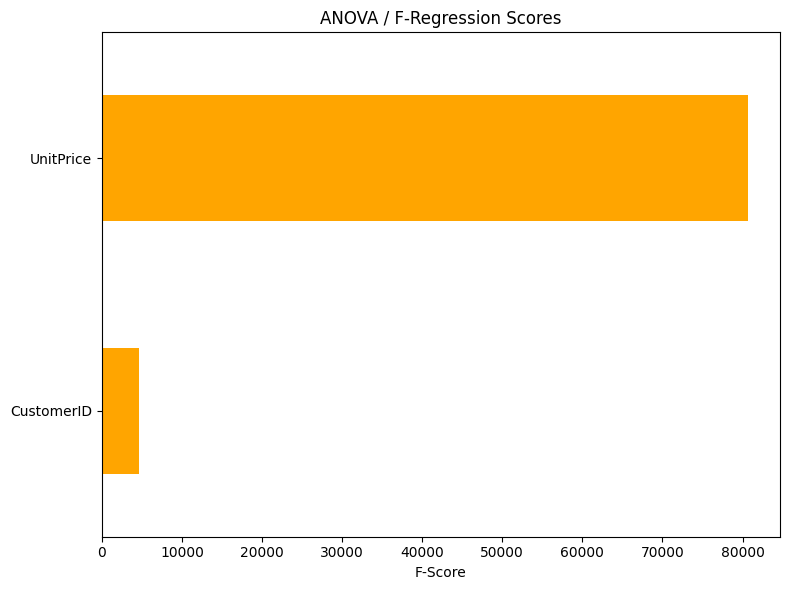


✅ Feature selection completed.


In [115]:
selected_features = feature_selection(cleaned_df, target_col='Quantity')


In [104]:
print(cleaned_df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


# Feature enginering

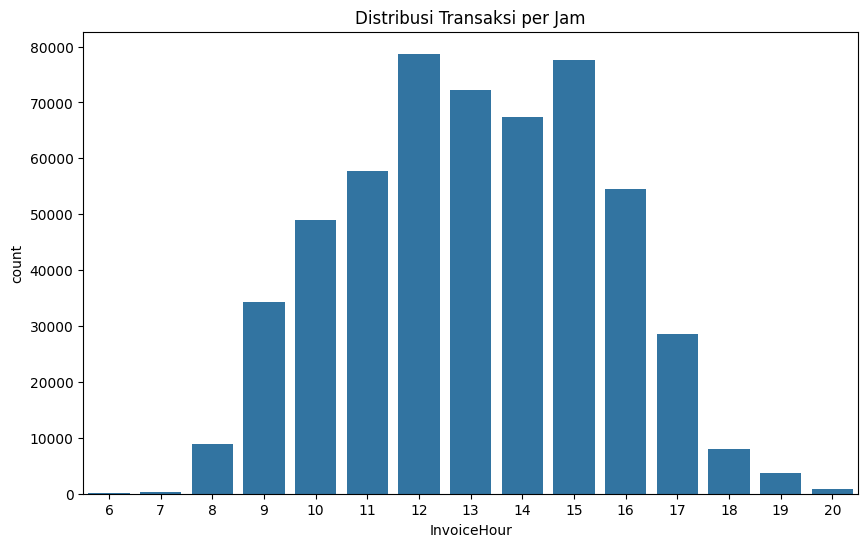

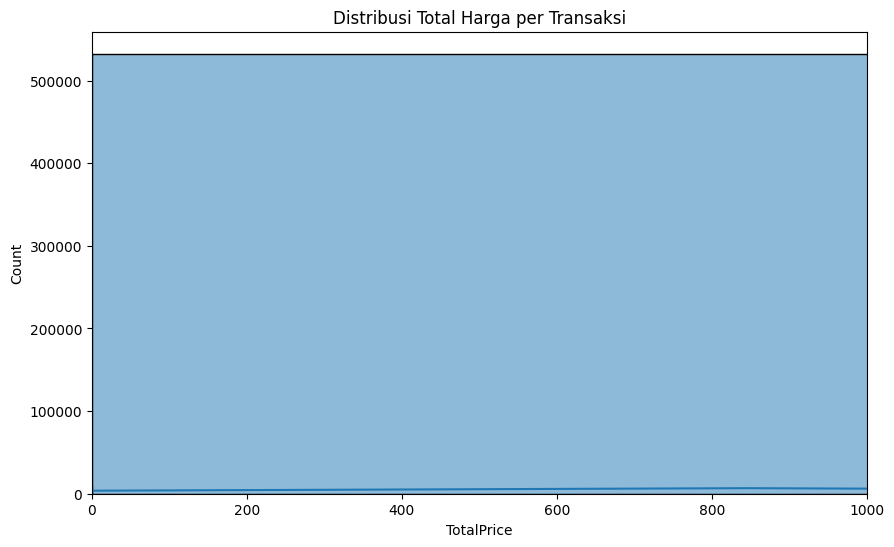

In [26]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# 2. Feature Engineering

# a. Ekstraksi fitur temporal
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek

# b. Membuat fitur TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 3. Visualisasi

# a. Distribusi transaksi per jam
plt.figure(figsize=(10, 6))
sns.countplot(x='InvoiceHour', data=df)
plt.title('Distribusi Transaksi per Jam')
plt.show()

# b. Distribusi total harga
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalPrice'], bins=50, kde=True)
plt.title('Distribusi Total Harga per Transaksi')
plt.xlim(0, 1000)
plt.show()

# 4. Standardisasi/Normalisasi

# Pilih kolom numerik
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice']

# a. Standardisasi
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])
# b. Normalisasi (Opsional)
minmax_scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numeric_cols] = minmax_scaler.fit_transform(df[numeric_cols])


# clustering model dan matrick evaluasi




Starting clustering evaluation...

Evaluating KMeans...
Completed in 0.2s | Clusters: 4 | Silhouette: 0.726


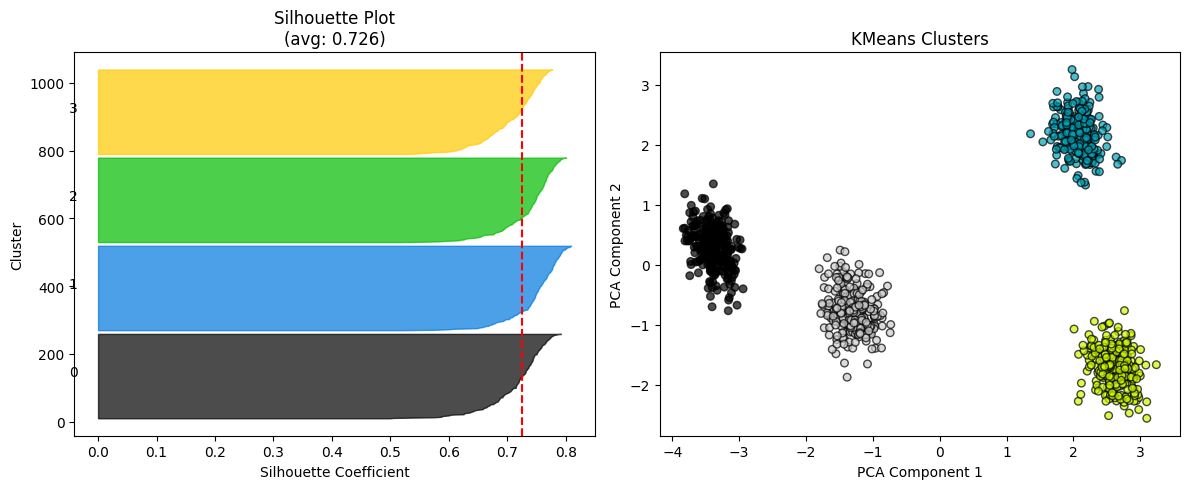


Evaluating Agglomerative...
Completed in 0.4s | Clusters: 4 | Silhouette: 0.726


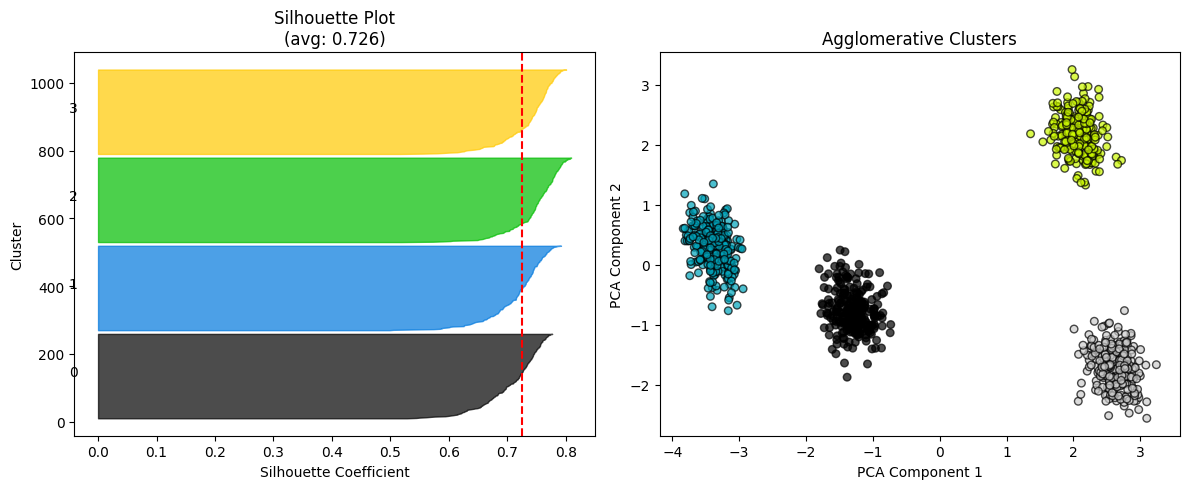


Evaluating DBSCAN...
Completed in 0.3s | Clusters: 5 | Silhouette: 0.694


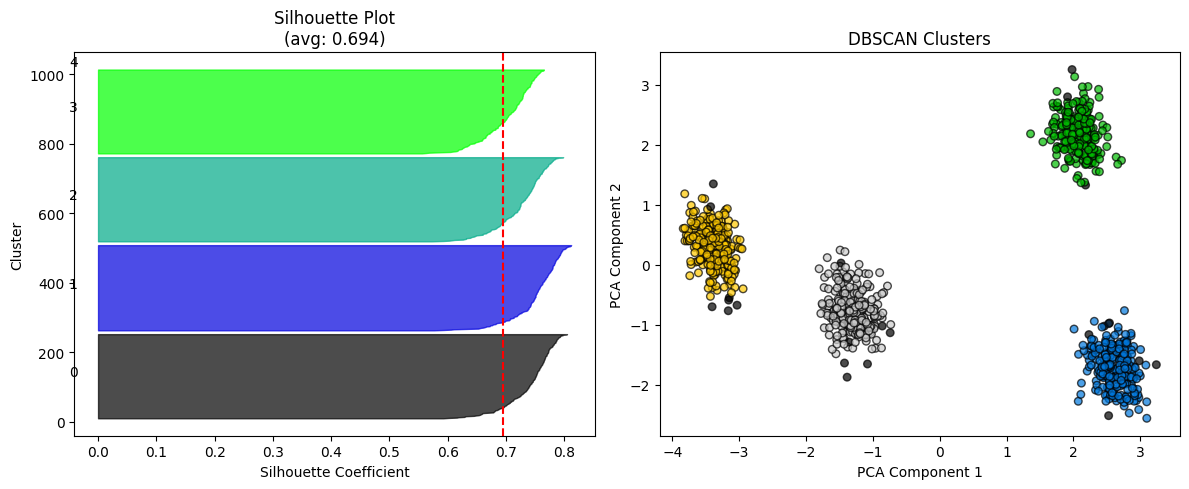


Evaluating GMM...
Completed in 1.3s | Clusters: 4 | Silhouette: 0.726


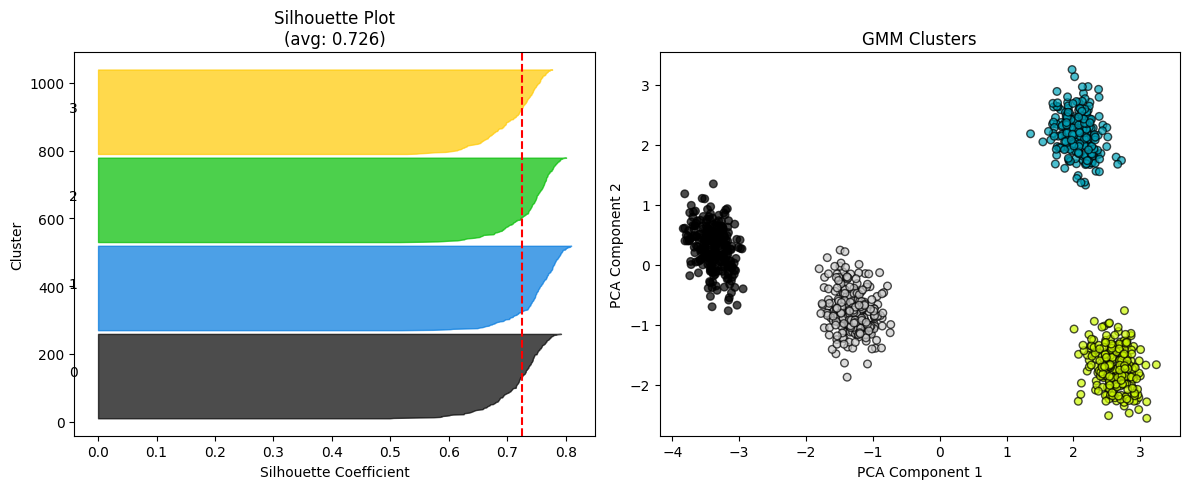


Evaluating Spectral...
Completed in 1.6s | Clusters: 4 | Silhouette: 0.726


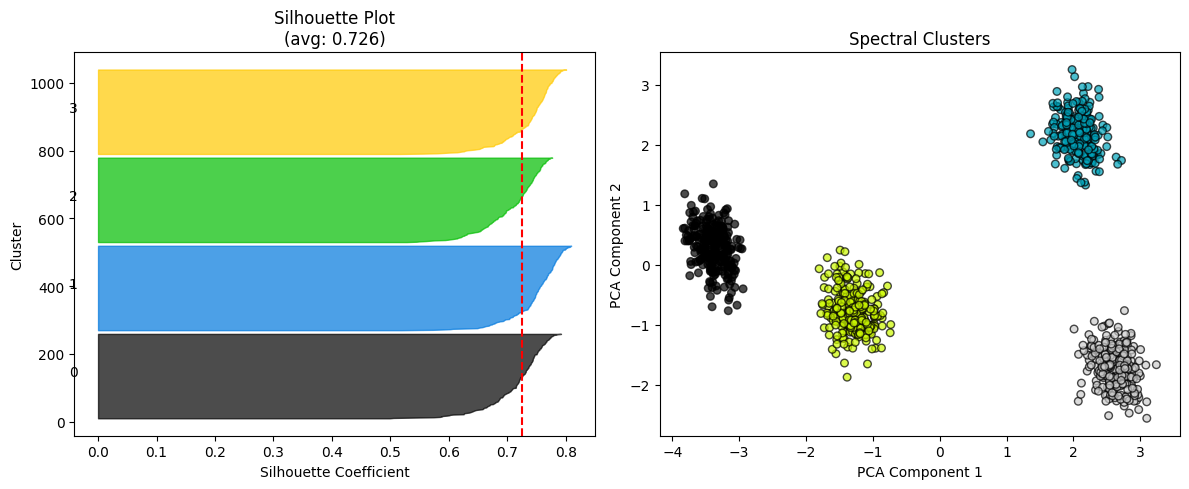


=== BEST MODEL ===
Algorithm: KMeans
Parameters: {'n_clusters': 4}
Silhouette: 0.726
Clusters: 4

=== MODEL COMPARISON ===
       algorithm  n_clusters  silhouette  davies_bouldin  calinski_harabasz
0         KMeans           4    0.726029        0.399881        4732.908044
1  Agglomerative           4    0.726029        0.399881        4732.908044
3            GMM           4    0.726029        0.399881        4732.908044
4       Spectral           4    0.726029        0.399881        4732.908044
2         DBSCAN           5    0.694306        1.471349        2592.535778


In [27]:
import time
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from matplotlib import cm
from sklearn.utils import resample

class ClusteringOptimizer:
    def __init__(self, max_samples=5000, random_state=42):
        self.max_samples = max_samples
        self.random_state = random_state
        self.results = []

    def fit_evaluate(self, X, algorithms=None, true_labels=None):
        """Evaluasi beberapa algoritma clustering sekaligus"""
        if not hasattr(X, 'shape'):
            X = np.array(X)

        if algorithms is None:
            algorithms = self._get_default_algorithms()

        # Sampling data jika terlalu besar
        if len(X) > self.max_samples:
            X = resample(X, n_samples=self.max_samples,
                        random_state=self.random_state, replace=False)
            print(f"Using sampled {len(X)}/{self.max_samples} points")

        # Standardisasi data
        X_scaled = StandardScaler().fit_transform(X)

        # Evaluasi setiap algoritma
        for name, config in algorithms.items():
            print(f"\nEvaluating {name}...")
            start_time = time.time()

            try:
                result = self._evaluate_single(
                    X_scaled, name, config['model'], config['params'], true_labels
                )
                self.results.append(result)
                print(f"Completed in {time.time()-start_time:.1f}s | "
                      f"Clusters: {result['n_clusters']} | "
                      f"Silhouette: {result['silhouette']:.3f}")

                # Visualisasi
                self._visualize_result(X_scaled, result)

            except Exception as e:
                print(f"Failed to evaluate {name}: {str(e)}")

        return self.results

    def _evaluate_single(self, X, name, model, params, true_labels=None):
        """Evaluasi single clustering algorithm"""
        from itertools import product

        best_score = -np.inf
        best_params = {}
        best_labels = None

        # Grid search sederhana
        param_names = list(params.keys())
        param_values = list(params.values())

        for values in product(*param_values):
            current_params = dict(zip(param_names, values))

            try:
                current_model = clone(model).set_params(**current_params)

                if hasattr(current_model, 'fit_predict'):
                    labels = current_model.fit_predict(X)
                else:  # Untuk GMM
                    current_model.fit(X)
                    labels = current_model.predict(X)

                # Skip jika hanya 1 cluster
                if len(np.unique(labels)) < 2:
                    continue

                score = silhouette_score(X, labels)

                if score > best_score:
                    best_score = score
                    best_params = current_params
                    best_labels = labels

            except Exception:
                continue

        if best_labels is None:
            raise ValueError("No valid clusters found")

        # Hitung semua metrik
        result = {
            'algorithm': name,
            'params': best_params,
            'labels': best_labels,
            'n_clusters': len(np.unique(best_labels)),
            'silhouette': best_score,
            'davies_bouldin': davies_bouldin_score(X, best_labels),
            'calinski_harabasz': calinski_harabasz_score(X, best_labels),
        }

        if true_labels is not None:
            from sklearn.metrics import adjusted_rand_score
            result['ari'] = adjusted_rand_score(true_labels[:len(best_labels)], best_labels)

        return result

    def _visualize_result(self, X, result):
        """Visualisasi hasil clustering"""
        plt.figure(figsize=(12, 5))

        # Plot silhouette
        plt.subplot(1, 2, 1)
        self._plot_silhouette(X, result['labels'], result['silhouette'])

        # Plot clusters
        plt.subplot(1, 2, 2)
        self._plot_clusters(X, result['labels'], result['algorithm'])

        plt.tight_layout()
        plt.show()

    def _plot_silhouette(self, X, labels, silhouette_avg):
        """Plot silhouette coefficients"""
        n_clusters = len(np.unique(labels))
        sample_silhouette_values = silhouette_samples(X, labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_values = sample_silhouette_values[labels == i]
            ith_cluster_values.sort()

            size_cluster_i = len(ith_cluster_values)
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.title(f"Silhouette Plot\n(avg: {silhouette_avg:.3f})")
        plt.xlabel("Silhouette Coefficient")
        plt.ylabel("Cluster")

    def _plot_clusters(self, X, labels, algorithm_name):
        """Visualisasi 2D clusters"""
        if X.shape[1] > 2:
            X_vis = PCA(n_components=2).fit_transform(X)
            xlabel, ylabel = "PCA Component 1", "PCA Component 2"
        else:
            X_vis = X
            xlabel, ylabel = "Feature 1", "Feature 2"

        plt.scatter(X_vis[:, 0], X_vis[:, 1],
                   c=labels, cmap='nipy_spectral',
                   marker='o', s=30, alpha=0.7, edgecolor='k')
        plt.title(f"{algorithm_name} Clusters")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    def _get_default_algorithms(self):
        """Default algorithms to evaluate"""
        return {
            'KMeans': {
                'model': KMeans(random_state=self.random_state),
                'params': {'n_clusters': range(2, 8)}
            },
            'Agglomerative': {
                'model': AgglomerativeClustering(),
                'params': {'n_clusters': range(2, 8)}
            },
            'DBSCAN': {
                'model': DBSCAN(),
                'params': {'eps': [0.3, 0.5, 0.7], 'min_samples': [5, 10]}
            },
            'GMM': {
                'model': GaussianMixture(random_state=self.random_state),
                'params': {'n_components': range(2, 8)}
            },
            'Spectral': {
                'model': SpectralClustering(random_state=self.random_state),
                'params': {'n_clusters': range(2, 8)}
            }
        }

    def get_best_model(self, metric='silhouette'):
        """Dapatkan model terbaik berdasarkan metrik tertentu"""
        if not self.results:
            raise ValueError("No results available. Please run fit_evaluate() first.")

        if metric == 'silhouette':
            idx = np.argmax([r['silhouette'] for r in self.results])
        elif metric == 'davies_bouldin':  # Lower is better
            idx = np.argmin([r['davies_bouldin'] for r in self.results])
        elif metric == 'calinski_harabasz':
            idx = np.argmax([r['calinski_harabasz'] for r in self.results])
        else:
            raise ValueError("Invalid metric. Choose: 'silhouette', 'davies_bouldin', 'calinski_harabasz'")

        return self.results[idx]

# Contoh penggunaan yang benar:
if __name__ == "__main__":
    # 1. Siapkan data
    from sklearn.datasets import make_blobs
    X, y = make_blobs(n_samples=1000, centers=4, n_features=10, random_state=42)

    # 2. Inisialisasi optimizer
    optimizer = ClusteringOptimizer(max_samples=1000)

    # 3. Jalankan evaluasi
    print("Starting clustering evaluation...")
    results = optimizer.fit_evaluate(X, true_labels=y)

    # 4. Dapatkan model terbaik
    try:
        best_model = optimizer.get_best_model()
        print("\n=== BEST MODEL ===")
        print(f"Algorithm: {best_model['algorithm']}")
        print(f"Parameters: {best_model['params']}")
        print(f"Silhouette: {best_model['silhouette']:.3f}")
        print(f"Clusters: {best_model['n_clusters']}")
    except ValueError as e:
        print(f"Error: {e}")

    # 5. Tampilkan perbandingan
    print("\n=== MODEL COMPARISON ===")
    comparison = pd.DataFrame(optimizer.results)[
        ['algorithm', 'n_clusters', 'silhouette', 'davies_bouldin', 'calinski_harabasz']
    ]
    print(comparison.sort_values('silhouette', ascending=False))